In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
from numpy.random import RandomState

from util.defs import *
from hp_optimizers.hp_optimizer import GPROptimizer, RandomSearchOptimizer
from acquisition.acquisition_functions import ProbabilityOfImprovement, ExpectedImprovement
from acquisition.acquisition_optimizers import RandomAcquisitionOpt, ConstrainedAcquisitionOpt

sns.set_style("darkgrid")

In [2]:
rand = RandomState(seed=54321)
# rand = RandomState()

# Simple objective function

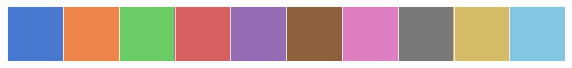

In [3]:
grid_step = 0.001
colors = sns.color_palette("muted")
sns.palplot(colors)

def objective(X, noise=0.01):
    # This is a stand-in for a real objective
    noise = rand.normal(loc=0, scale=noise, size=X.shape)
    # want to do a minimization, so negate & translate up by 1.5
    return -(X**2 * np.sin(5 * np.pi * X)**6) + 1 + noise


def plot_objective(ax1, ax2):
    X = np.arange(0, 1, grid_step)[:, np.newaxis]
    y_noisy = objective(X)
    y_true = objective(X, noise=0.0)
    
    ax1.set_title('(a)')
    ax2.set_title('(b)')
    sns.lineplot(x=X[:, 0], y=y_true[:, 0], ax=ax1, color="black")
    sns.lineplot(x=X[:, 0], y=y_noisy[:, 0], ax=ax2, color="black")
    return y_noisy.min(), y_noisy.max()

    
def plot_gpr_obj(X, y, model, ax, ylims):
    X_grid = np.arange(0, 1, grid_step)[:, np.newaxis]
    y_grid, std = model.predict(X_grid, return_std=True)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(ylims[0], ylims[1])
    ax.fill_between(X_grid[:, 0], y_grid[:, 0] + std, y_grid[:, 0] - std, color=colors[1])
    sns.scatterplot(X[:, 0], y[:, 0], ax=ax, color=colors[0])
    sns.lineplot(X_grid[:, 0], y_grid[:, 0], ax=ax, color="black")

True min: 0.1780596133046172


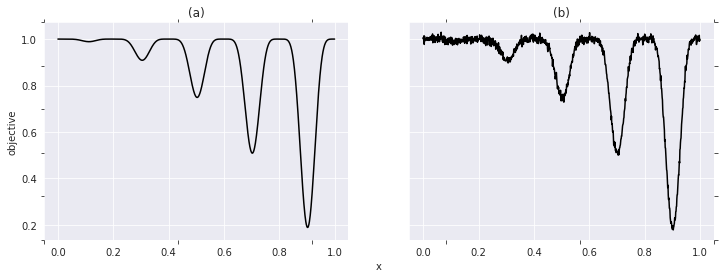

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
obj_min, obj_max = plot_objective(ax1, ax2)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("x")
plt.ylabel("objective")

# plt.show()
plt.savefig("obj_fun.png")
print(f"True min: {obj_min}")

In [5]:
bounds = np.array([
    [0.0, 1.0],
])
p_types = [ParamType.Cont]

In [6]:
def init_gpr():
    kernel = gp.kernels.RBF()
    # Defining the scale parameter here is cheating a bit (since used the same value when generating the data)
    gpr = gp.GaussianProcessRegressor(kernel, 
                                      alpha=np.abs(rand.normal(scale=.0001)),
                                      n_restarts_optimizer=21, 
                                      random_state=rand,
                                      normalize_y=True)
    return gpr


def get_acq_opt(idx, gpr, rand):
    pi = ProbabilityOfImprovement()
    ei = ExpectedImprovement()
    if idx == 0:
        return RandomAcquisitionOpt(gpr, pi, rand), 'a'
    elif idx == 1:
        return RandomAcquisitionOpt(gpr, ei, rand), 'b'
    elif idx == 2:
        return ConstrainedAcquisitionOpt(gpr, pi, rand), 'c'
    elif idx == 3:
        return ConstrainedAcquisitionOpt(gpr, ei, rand), 'd'

In [7]:
opt_rounds = 20

# Simple random

# SMBO

{'argmin': 17, 'minimizer': array([0.90401067]), 'minimum': array([0.19632363])}
{'argmin': 7, 'minimizer': array([0.8968871]), 'minimum': array([0.18642283])}


/home/carcook/anaconda3/envs/cs446-gp-env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/carcook/anaconda3/envs/cs446-gp-env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


{'argmin': 14, 'minimizer': array([0.89869088]), 'minimum': array([0.18842184])}
{'argmin': 21, 'minimizer': array([0.901592]), 'minimum': array([0.16963095])}


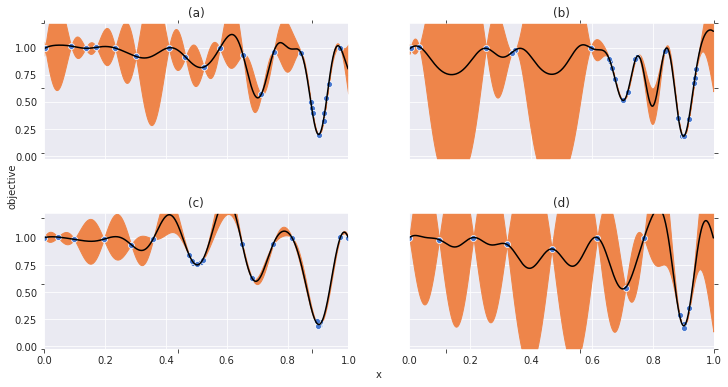

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={"wspace": 0.2, "hspace": 0.4}, sharex=True, sharey=True)

for r in range(2):
    for c in range(2):
        gpr = init_gpr()
        opt_acquisition, ch = get_acq_opt(r * 2 + c, gpr, rand)
        gpr_opt = GPROptimizer(gpr, opt_acquisition, objective, bounds, p_types, rand, initial_samples=3, fit=True)
        res = gpr_opt.optimize(opt_rounds)
        print(res)
        plot_gpr_obj(gpr_opt.X, gpr_opt.y, gpr_opt.gpr, axes[r][c], (obj_min - 0.2, obj_max + 0.2))
#         t = titles[r * 2 + c]
        axes[r][c].set_title(f"({ch})")

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("x")
plt.ylabel("objective")
    
# plt.show()
plt.savefig("simple_1d_exp.png")

In [9]:
X_rand = rand.uniform(size=(opt_rounds + 3, 1))
y_vals = objective(X_rand)
y_min = y_vals.min()
X_min = X_rand[np.argmin(y_vals)]
print(f"Best X: {X_min}, best y: {y_min}")

Best X: [0.88330093], best y: 0.3508601252656285
